123489


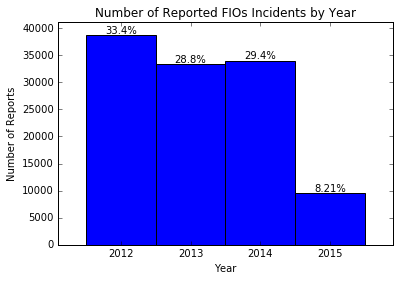

6
6
6
6


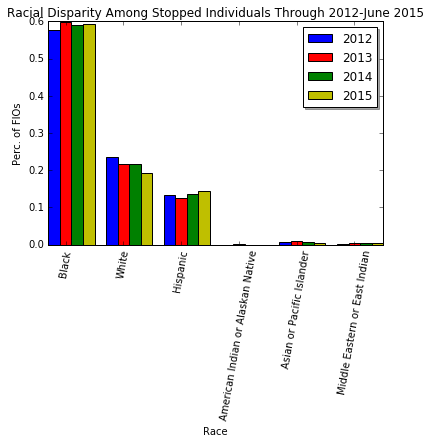

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sys
  
    
# Visual Modules
from IPython.display import display, HTML
%matplotlib inline


# Global list for use throughout
YEARS = ['2012', '2013', '2014', '2015']

# Read in our FIO data
df = pd.read_csv('datasets/bpd-field-interrogation-and-observation-reports.csv')

# First, a preliminary analysis of how FIOs have changed through the years:
# Add the year column to our dataframe so as to group by it.
years = []
for entry in df.FIO_DATE:
    curr_year = entry[6:10]
    years.append(curr_year)
df['Year'] = pd.Series(years, index=df.index) # Append our newly created column to our DataFrame.


# Now we can groupby our new 'Year' attribute and get the raw number of FIOs per year.
df_years = df.groupby('Year').count()['SEQ_NUM']
years_to_analyze = [count for index, count in df_years.iteritems() if index in YEARS]


def plot_raw_fios(year_to_analyze):
    '''Plots the raw number of FIOs per year, given that data'''
    # Plot data
    total_count = 0
    for year in year_to_analyze:
        total_count += year

    fig, ax = plt.subplots()
    plt.title('Number of Reported FIOs Incidents by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Reports')
    
    plt.xticks(np.arange(len(years_to_analyze)), YEARS)
    rects = plt.bar(np.arange(len(years_to_analyze)), years_to_analyze,  align = "center", width = 1)
    plt.ylim(0, max(years_to_analyze) + 2500) #leaving room for the percentage labels
    ax.margins(0.1, None)
    
    #apply percentage labels on each bar
    for rect in rects:  
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.,height,
            str((height/total_count) * 100)[:4] + "%", ha='center', va='bottom')
    plt.show()



# Now, lets see how the racial disparity in FIOs incidents has changed over the same years
def get_race_data(df):
    '''Rips racial disparity data from our dataframe, and normalizes it
    so as to provide a look in to the breakdown of which races are being stopped.'''
    
    races = df['RACE_DESC'].unique()
    race_by_year = {key: collections.OrderedDict() for key in YEARS}
    
    for key in race_by_year:
        for race in races:
            race_by_year[key][race] = 0
        
    for index, row in df.iterrows():
        if row['Year'] not in YEARS:
            continue
    
        race_by_year[row['Year']][row['RACE_DESC']] += 1

    for year in YEARS:
        current = race_by_year[year]
        curr_sum = sum(current.values())

        for key in current:
            race_by_year[year][key] /= curr_sum
            
    return race_by_year, races

def plot_2015():
    df = pd.read_csv('datasets/stop_and_frisk.csv').fillna('')
    races  = df['RACE'].unique()
    #print(races)
    
    totals = {key:0 for key in races if key not in ['', 'Unknown']}
    for index, item in df.iterrows():
        if item['RACE'] not in totals:
            continue
        totals[item['RACE']] += 1
    
    for key in totals:
        totals[key] /= len(df['RACE'])
    
    return totals

def plot_disparity(race_by_year, races):
    '''Plots over 4 years how the change in disparity has changed
    with respect to the races of individuals stopped.'''
    
    fig, ax = plt.subplots()
    plt.title('Racial Disparity Among Stopped Individuals Through 2012-June 2015')
    plt.xlabel('Race')
    plt.ylabel('Perc. of FIOs')
    
    plt.xticks(range(len(races)), races, rotation=60)

    for year in YEARS:
        stats = [race_by_year[year][race] for race in races if race not in "NO DATA ENTERED UNKNOWN"]
        print(len(stats))
        xlabels = [race.split("(")[1][:-1] for race in races if race not in "NO DATA ENTERED UNKNOWN"]
        if(year == '2012'):
            plt.bar(np.arange(len(stats))-0.3, stats, label=year, color = 'b', width = 0.2)
        elif (year == '2013'):
            plt.bar(np.arange(len(stats))-0.1, stats, label=year, color = 'r', width = 0.2)      
        elif (year == '2014'):
            plt.bar(np.arange(len(stats))+0.1, stats, label=year, color = 'g', width = 0.2)
        elif (year == '2015'):
            plt.bar(np.arange(len(stats))+0.3, stats, label=year, color = 'y', width = 0.2)
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation = 80)
    plt.legend(loc='best', shadow=True)
    plt.show()

    
# Draw our plots
plot_raw_fios(years_to_analyze)
race_by_year, races = get_race_data(df)
plot_disparity(race_by_year, races)

#
# We can also see what percentage of BPD officers are involved in these incidents:
#


In [21]:
import statsmodels.api as sm

# Now, we'll do linear regreesion to see how each of the several attributes in our dataset contributes to the overall
# number of stop and frisks for a given year

# For each district, a data object consisting of: 
# Number of crime incidents (Percentage?); Percentage of each major race (Census) as seveeral attribtues; 
# Percentage of each Sex in district (Census); FIO number for each district
#
# Output attribute: FIO number for each district/# of Crime incidents
#
# Note that statistics regarding racial composition of particular districts taken from: 
# chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/http://www.cityofboston.gov/images_documents/Redistricting_tcm3-10195.pdf
#
#
# Charlestown, East Boston, North End: 64.7% White, 3% Black, 25.3% Hispanic, 4% Asian/Pacific Islander, 35.3% Minority
# Downtown, South Boston, South End: 65.6% White, 7.9% Black, 9.5%, 14.6% Asian/Pacific Islander, 34.4% Minority
# Dorchester: 39.7% White, 28.3% Black, 9.9% Hispanic, 13.7% Asian/Pacific Islander, 60.3% Minority
# Dorchester/Mattapan: 4.2%, 72.9%, 15%, 1.5%, 95.8%
# Hyde Park: 43.8%, 34.5, 15.5%, 1.9%, 56.2% Minority
# Jamaica Plain, West Roxbury: 67%, 9,9%, 16.3%, 4.2%, 33%
# Roxbury: 20.4%, 47.9%, 20.3, 2.7, 79.6
# Allston, Brighton: 68.4, 4.5, 9.2, 13.9, 31.6
#
#


# Split Crime Data based on these divisions to create table that will be used for regression
# Read in our Crime Data, and bring down our FIO data from above.
df_crime = pd.read_csv('datasets/crime-indicent-reports-2012-2015.csv', dtype=str)
df_by_district = df_crime.groupby('REPTDISTRICT').count()['COMPNOS']


# A dictionary to hold our crime incident report data and our FIO data for each electoral district in Boston
# Note that the 0th index for each list will hold crime count through 2015, and the 1st index will hold
# FIO count through the same timeframe. 
electoral_district_stats = collections.OrderedDict([(('A15', 'A7'), [0,0]), (('C6', 'A1', 'A4'), [0,0]), (('C11'), [0,0]), (('B3'), [0,0]),
                           (('E18'), [0,0]), (('E5', 'E13'), [0,0]), (('B2'), [0,0]), (('D14'), [0,0])])

# Iterate through our FIO dataset, extracting the district from each entry only if the year 
# is from 2012-2015.
for index, row in df.iterrows():
    if row['Year'] in YEARS:
        for key in electoral_district_stats:
            if row['DIST'] in key:
                electoral_district_stats[key][1] += 1
                break

    
# Now we can add those policing districts together to make up a given electoral district
for index, value in df_by_district.iteritems():
    for key in electoral_district_stats:
        if index in key:
            electoral_district_stats[key][0] += value
            break


            
def create_dataset(district_stats):
    headers = ['Reported Crimes (2012-2015)', 'Reported FIOs (2012-2015)', 'White', 'Black', 'Hispanic', 'Asian/Pacific Islander']
    
    dataset = []
    for district, population in zip(district_stats, [67906, 63972, 63146, 64530, 67943, 63197, 64422, 66141]):
        dataset.append([district_stats[district][0] / population, district_stats[district][1] / population])
    
    
    # Hardcode in our census data; percentages of each of four main races in each district.
    dataset[0].extend([x/100 for x in [64.7, 3, 25.3, 4]])
    dataset[1].extend([x/100 for x in [65.6, 7.9, 9.5, 14.6]])
    dataset[2].extend([x/100 for x in [39.7, 28.3, 9.9, 13.7]])
    dataset[3].extend([x/100 for x in [4.2, 72.9, 15, 1.5]])
    dataset[4].extend([x/100 for x in [43.8, 34.5, 15.5, 1.9]])
    dataset[5].extend([x/100 for x in [67, 9.9, 16.3, 4.2]])
    dataset[6].extend([x/100 for x in [20.4, 47.9, 20.3, 2.7]])
    dataset[7].extend([x/100 for x in [68.4, 4.5, 9.2, 13.9]])
    
    df = pd.DataFrame(dataset, columns=headers)
    
    return df

def linear_analysis(df):
    '''Uses the constructed dataet to perform linear regression, first with FIO number as the output attribute,
    and then with the crime rate as the output attribute.'''
    
    y_train = df['Reported FIOs (2012-2015)']
    X_train = df.drop('Reported FIOs (2012-2015)', axis=1)
    
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    conf = results.conf_int()
    print(results.summary())
    

# Construct the dataset from the Census info and our crime/FIO stats
dataset = create_dataset(electoral_district_stats)
display(dataset)

# Perform regression
linear_analysis(dataset)

,Reported Crimes (2012-2015),Reported FIOs (2012-2015),White,Black,Hispanic,Asian/Pacific Islander
0,0.259859,0.088431,0.647,0.030,0.253,0.040
1,0.754346,0.296708,0.656,0.079,0.095,0.146
2,0.520524,0.239065,0.397,0.283,0.099,0.137
3,0.364637,0.296281,0.042,0.729,0.150,0.015
4,0.196444,0.037796,0.438,0.345,0.155,0.019
5,0.416871,0.121525,0.670,0.099,0.163,0.042
6,0.601177,0.489538,0.204,0.479,0.203,0.027
7,0.284302,0.027245,0.684,0.045,0.092,0.139


                                OLS Regression Results                               
Dep. Variable:     Reported FIOs (2012-2015)   R-squared:                       0.992
Model:                                   OLS   Adj. R-squared:                  0.978
Method:                        Least Squares   F-statistic:                     72.14
Date:                       Wed, 03 May 2017   Prob (F-statistic):            0.00252
Time:                               22:53:58   Log-Likelihood:                 18.951
No. Observations:                          8   AIC:                            -27.90
Df Residuals:                              3   BIC:                            -27.50
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------

C:\Users\elisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
